# 1. Bayesian optimization
*Deep Bayes summer school, 2018*

*A. Zaytsev, Y. Kapushev*

Content
1. Bayesian optimization overview
2. Overview of libraries
3. One dimensional example
4. AutoML: optimization of hyperparameters for machine learning model

# When Bayesian optimization?

* Optimization of "heavy" functions 
* The target function is a blackbox, typically noisy, while smooth


* Construction a regression model using available data
* Take into account uncertainty of the regression model
* Gaussian process regression is OK

## Optimization workflow:
1. Construct a regression model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function
$$
x_{new} = \arg\max\limits_x a(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

## Examples of the acquisation functions 

#### Upper confidence bound (UCB) 

$$
UСB(x) = \hat{f}(x) + \beta \hat{\sigma}(x),
$$
$\hat{f}(x), \hat{\sigma}(x)$ - mean and standard deviation of the Gaussian process regression model at $x$.

#### Expected Improvement (EI) 

$$
EI(x) = \mathbb{E}_{p(\hat{f})} \max(0, f_{min} - \hat{f}(x)). 
$$


Usually we use logarithm of EI.

<img src="EI_vs_logEI.png">

# 2. Bayesian optimization libraries:

| Library        | #commits           | #stars | #last commit |
| ------------- | -----:| -----:| -----:|
| hyperopt      | 950   | 2275  | 02.07.2018 | 
| BayesOpt      | 515   | 157   | 30.03.2018 | 
| GPyOpt        | 463   | 303   | 26.06.2018 |
| GPflowOpt     | 407   | 107   | 16.04.2018 | 
| pyGPGO        | 273   | 78    | 07.11.2017 | 

More libraries for Matlab (SUMO) and other languages.

*Actually it is not hard to write your own library on top of your favorite Gaussian Process Regression library.*


## Additional libraries

We need libraries for
* Gaussian process regression **GPy** (see previous seminar)
* Gaussian process regression-based Bayesian optimization **GPyOpt**

See more use cases of **GPyOpt** at http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb

To install GPyOpt run the following line

In [2]:
!pip install emcee
!pip install GPyOpt

    100% |████████████████████████████████| 61kB 762kB/s 
  Running setup.py bdist_wheel for GPyOpt ... done
  Stored in directory: /home/yeahrmek/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
Successfully built GPyOpt
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import GPy
import GPyOpt
import matplotlib.pyplot as plt
import numpy as np

# auxiliary functions
import utility
% matplotlib inline
from IPython.display import clear_output
from tqdm import trange

# emcee sampler is required to run Entropy search in GPyOpt

In [2]:
import utility

# 3. One dimensional example

We demonstrate concepts using one-dimensional example.

Let us consider Bayesian optimization for one-dimensional function **Forrester**:
$$
f(x) = (6 x - 2)^2 \sin(12 x - 4).
$$

The optimization problem is the following:
$$
f(x) \rightarrow \min, x \in [0, 1].
$$

In [3]:
# we can load it from GPyOpt library
forrester_function = GPyOpt.objective_examples.experiments1d.forrester()

In [4]:
forrester_function.f(np.array([0.5]))

array([[0.90929743]])

In [5]:
forrester_function.bounds

[(0, 1)]

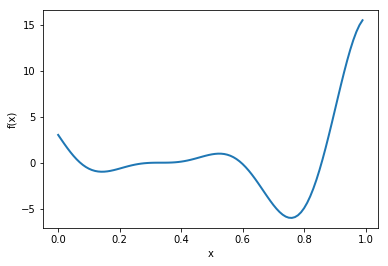

In [6]:
forrester_function.plot()

In [7]:
# Select the region where we search the optimum
space = [{'name': 'x', 'type': 'continuous', 'domain': (0, 1)}]
design_region = GPyOpt.Design_space(space=space)

In [8]:
# Select the initial design
from numpy.random import seed # fixed seed
seed(123456)

initial_sample_size = 5
initial_design = GPyOpt.experiment_design.initial_design('random', design_region, initial_sample_size)

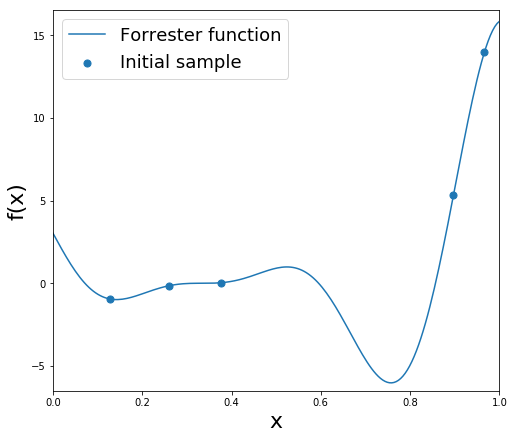

In [9]:
uniform_dense_grid = np.linspace(0, 1, 200).reshape(-1, 1)

# plot function: curve and values at the initial design points
utility.plot_one_dimensional_function(forrester_function, 
                                      uniform_dense_grid, 
                                      initial_design)

## We defined the problem - now we create a machine to solve it

1. A black box that evaluates the target function
2. What kind of the regression model we need
3. How do we optimize the acquisition function
4. What kind of the acquisition function we use
5. Should we use optimizer in batch or continuous mode?

In [10]:
# The target function
objective = GPyOpt.core.task.SingleObjective(forrester_function.f)

# Model type
gp_model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts=10, verbose=False) 
# exact_feval - are evaluations exact?
# optimize_restarts - number of restarts at each step
# verbose - how verbose we are

# Optimizer of the acquisition function, the default is 'LBFGS'
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(design_region)

# The acquisition function is expected improvement
acquisition_function = GPyOpt.acquisitions.AcquisitionEI(gp_model, design_region, optimizer=aquisition_optimizer)

# How we collect the data
evaluator = GPyOpt.core.evaluators.Sequential(acquisition_function)

In [11]:
# Now we are ready to construct the machine
bayesian_optimizer = GPyOpt.methods.ModularBayesianOptimization(gp_model, design_region, objective, 
                                                acquisition_function, evaluator, initial_design)

### Run the first six iterations

In [12]:
# Stopping criteria
max_time = None 
max_number_of_iterations = 5
tolerance = 1e-8 # distance between consequitive observations

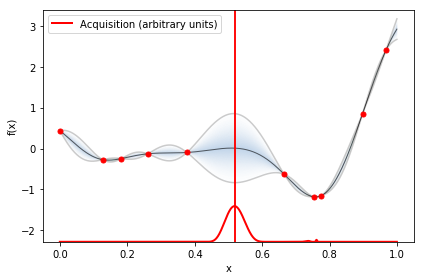

In [13]:
# Run five iterations
for iteration in range(max_number_of_iterations):
    bayesian_optimizer.run_optimization(max_iter=1, max_time=max_time, 
                                        eps=tolerance, verbosity=False) 
  
    bayesian_optimizer.plot_acquisition()
    clear_output(wait=True)

### Now we run more iterations - 25

In [14]:
bayesian_optimizer = GPyOpt.methods.ModularBayesianOptimization(gp_model, design_region, objective, 
                                                acquisition_function, evaluator, initial_design)

max_number_of_iterations = 25
bayesian_optimizer.run_optimization(max_iter=max_number_of_iterations, max_time=max_time, 
                                    eps=tolerance, verbosity=False)

### Analyze problems

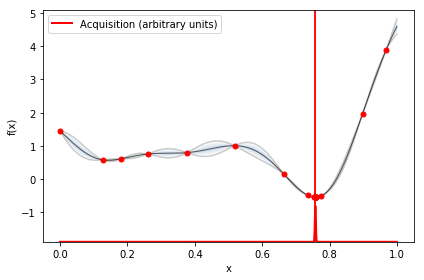

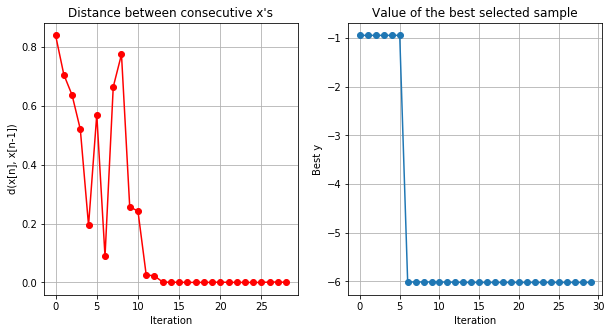

In [15]:
bayesian_optimizer.plot_acquisition()
bayesian_optimizer.plot_convergence()

In [16]:
print('Obtained xmin:  %.3f, real xmin:  %.3f (approximate)' % (bayesian_optimizer.x_opt, forrester_function.min))
print('Obtained fmin: %.3f, real fmin: %.3f (approximate)' % (bayesian_optimizer.fx_opt, forrester_function.fmin))

Obtained xmin:  0.757, real xmin:  0.780 (approximate)
Obtained fmin: -6.021, real fmin: -6.000 (approximate)


### Problem 1.1

Compare various acquisition functions EI, UCB and PI

In [17]:
# Your code below. Use EI, UCB and PI acquisition functions
number_of_runs = 10
obtained_targets_history_EI = []
for index in trange(number_of_runs):
    seed(index)
  
    obtained_targets_history_EI.append(utility.run_bayesian_optimization('EI'))

# your code below for other criteria
obtained_targets_history_UCB = []
for index in trange(number_of_runs):
    seed(index)
  
    obtained_targets_history_UCB.append(utility.run_bayesian_optimization('UCB'))
    
obtained_targets_history_PI = []
for index in trange(number_of_runs):
    seed(index)
  
    obtained_targets_history_PI.append(utility.run_bayesian_optimization('PI'))

100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


In [18]:
initial_sample_size = 5
obtained_targets_history_EI = np.array(obtained_targets_history_EI)
obtained_targets_history_UCB = np.array(obtained_targets_history_UCB)
obtained_targets_history_PI = np.array(obtained_targets_history_PI)

In [19]:
np.shape(obtained_targets_history_EI)

(10, 15)

In [20]:
obtained_targets_history_EI_cut = obtained_targets_history_EI[:, initial_sample_size:]
obtained_targets_history_UCB_cut = obtained_targets_history_UCB[:, initial_sample_size:]
obtained_targets_history_PI_cut = obtained_targets_history_PI[:, initial_sample_size:]

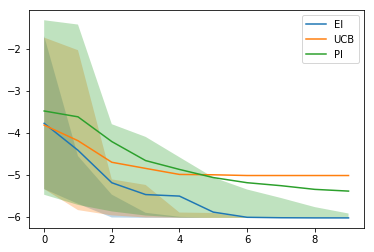

In [21]:
interations_number = 10
iterations = range(interations_number)

lower_percentile = 25 
upper_percentile = 75 

plt.plot(iterations, np.mean(obtained_targets_history_EI_cut, axis=0), label='EI')
plt.fill_between(iterations, 
                 np.percentile(obtained_targets_history_EI_cut, axis=0, q=lower_percentile),
                 np.percentile(obtained_targets_history_EI_cut, axis=0, q=upper_percentile), alpha=0.3)

plt.plot(iterations, np.mean(obtained_targets_history_UCB_cut, axis=0), label='UCB')        
plt.fill_between(iterations, 
                 np.percentile(obtained_targets_history_UCB_cut, axis=0, q=lower_percentile),
                 np.percentile(obtained_targets_history_UCB_cut, axis=0, q=upper_percentile), alpha=0.3)

plt.plot(iterations, np.mean(obtained_targets_history_PI_cut, axis=0), label='PI')
plt.fill_between(iterations, 
                 np.percentile(obtained_targets_history_PI_cut, axis=0, q=lower_percentile),
                 np.percentile(obtained_targets_history_PI_cut, axis=0, q=upper_percentile), alpha=0.3)
plt.legend(loc='upper right')

# Problem 1.2 

Select the best $\beta$ for UCB acquisition function wrt mean regret.

In [22]:
# TODO select different values of beta to get the best one
number_of_runs = 5
obtained_targets_history_beta = []
beta_space = np.logspace(0.1, 10, 5)
for beta in beta_space:
    obtained_targets_history_UCB = []
    for index in trange(number_of_runs):
        seed(index)

        obtained_targets_history_UCB.append(utility.run_bayesian_optimization('UCB', beta=beta))
    obtained_targets_history_beta.append(obtained_targets_history_UCB)

100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


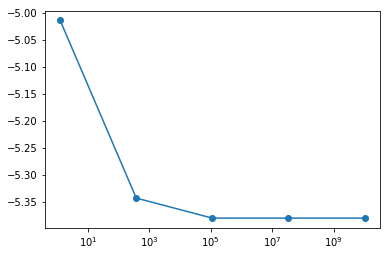

In [28]:
plt.semilogx(beta_space, [np.mean(np.array(x)[:, -1]) for x in obtained_targets_history_beta], '-o');

# 4. Bayesian optimization for the parameters of Gradient boosting

Now we optimize hyperparameters for Gradient boosting of decision trees.

In [16]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_auc_score

If lightgbm is not installed, please run the following cell

In [ ]:
!pip install lightgbm

In [36]:
import lightgbm as lgb

### We predict defaults for the classification problem

The goal is to predict if the two years absense of payments occur.

In [29]:
# Load the training sample
data = pd.read_csv('training_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 11 columns):
SeriousDlqin2yrs                        5001 non-null int64
RevolvingUtilizationOfUnsecuredLines    5001 non-null float64
age                                     5001 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    5001 non-null int64
DebtRatio                               5001 non-null float64
MonthlyIncome                           4031 non-null float64
NumberOfOpenCreditLinesAndLoans         5001 non-null int64
NumberOfTimes90DaysLate                 5001 non-null int64
NumberRealEstateLoansOrLines            5001 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    5001 non-null int64
NumberOfDependents                      4859 non-null float64
dtypes: float64(4), int64(7)
memory usage: 429.9 KB


In [30]:
points = data[['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']]
targets = data['SeriousDlqin2yrs']

In [43]:
lgb_ensemble = lgb.LGBMClassifier()

In [44]:
cross_validation_result = cross_validate(lgb_ensemble, 
                                         points, targets, 
                                         scoring='roc_auc')
print(np.mean(cross_validation_result['test_score']))

0.8101415850260475


In [45]:
# Define the region
hyperparameters_space = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0.05, 0.2)},
         {'name': 'n_estimators', 'type': 'discrete', 'domain': np.arange(10, 200)},
         {'name': 'subsample', 'type': 'continuous', 'domain': (0.75, 1.)}]
# We are interested in the following variables:
# 'continuous', 
# 'discrete', 
# 'categorical',

hyperparameters_design_region = GPyOpt.Design_space(space=hyperparameters_space)

In [34]:
def get_cv_quality(model_parameters_list):
    r"""
  
    Quality of model using given hyperparameters

    Inputs
    --------
    model_parameters : np.array
      numpy array of hyperparameteres specified in the same way as a domain

    Outputs
    --------
    minus_roc_auc : float
      minus mean value of ROC AUC calculated via cross validation
    """
    test_score_list = []
    for model_parameters in model_parameters_list:
        classification_model = lgb.LGBMClassifier()

        dict_model_parameters = dict(zip([element['name'] for element in hyperparameters_space], 
                                         model_parameters))
      
        # transform types to int for discrete variables
        for key in dict_model_parameters:
            hyperparameter_description = [x for x in hyperparameters_space if x['name'] == key][0]
            if hyperparameter_description['type'] == 'discrete':
                dict_model_parameters[key] = int(dict_model_parameters[key])
            
        classification_model.set_params(**dict_model_parameters)
        test_score = -np.mean(cross_validate(classification_model, 
                              points, targets, scoring='roc_auc')['test_score'])
        test_score_list.append(test_score)
    return test_score

In [52]:
get_cv_quality([[]])

-0.8101415850260475

In [48]:
get_cv_quality([[0.1, 20., 0.9]])

-0.8357286819716725

### Run Bayesian optimization

In [50]:
hyperparameters_optimization_problem = GPyOpt.methods.BayesianOptimization(get_cv_quality,  # function to optimize       
                                          domain=hyperparameters_space,         # box-constrains of the problem
                                          acquisition_type='EI')   # Exploration exploitation
hyperparameters_optimization_problem.run_optimization(max_iter=50)

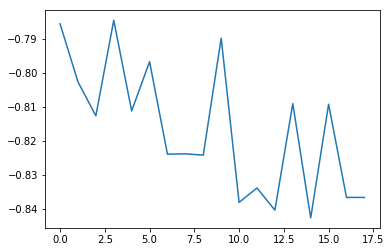

In [53]:
plt.plot(hyperparameters_optimization_problem.Y);

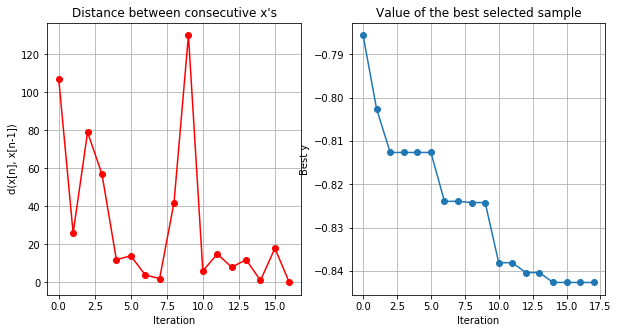

In [54]:
hyperparameters_optimization_problem.plot_convergence()

## Validate parameters using a test sample

In [31]:
# Load the testing sample
test_data = pd.read_csv('test_data.csv')

In [32]:
test_points = test_data[['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']]
test_targets = test_data['SeriousDlqin2yrs']

In [57]:
initial_model = lgb.LGBMClassifier()
initial_model.fit(points, targets)
test_predicted_probabilities = initial_model.predict_proba(test_points)[:, 1]
print(roc_auc_score(test_targets, test_predicted_probabilities))

0.8028561649532023


In [58]:
hyperparameters_optimization_problem.x_opt

array([ 0.05, 27.  ,  0.75])

In [59]:
best_model = lgb.LGBMClassifier(learning_rate=hyperparameters_optimization_problem.x_opt[0], 
                                n_estimators=int(hyperparameters_optimization_problem.x_opt[1]),
                                subsample=hyperparameters_optimization_problem.x_opt[2])
best_model.fit(points, targets)
test_predicted_probabilities = best_model.predict_proba(test_points)[:, 1]
print(roc_auc_score(test_targets, test_predicted_probabilities))

0.8255321122633724


# Problem 2.1 

Try to optimize another parameter of Gradient boosting

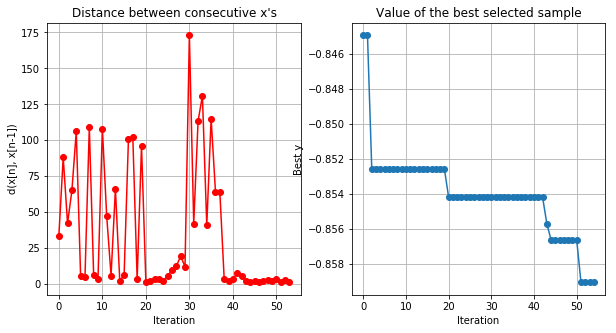

In [37]:
# TODO define another hyperparameters space and optimise hyperparameters in it
hyperparameters_space = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0.05, 0.2)},
                         {'name': 'n_estimators', 'type': 'discrete', 'domain': np.arange(10, 200)},
                         {'name': 'subsample', 'type': 'continuous', 'domain': (0.75, 1.)},
                         {'name': 'max_depth', 'type': 'discrete', 'domain': np.arange(1, 10)}]

hyperparameters_optimization_problem = GPyOpt.methods.BayesianOptimization(get_cv_quality,  # function to optimize       
                                          domain=hyperparameters_space,         # box-constrains of the problem
                                          acquisition_type='EI')   # Exploration exploitation
hyperparameters_optimization_problem.run_optimization(max_iter=50)
hyperparameters_optimization_problem.plot_convergence()

In [39]:
best_model = lgb.LGBMClassifier(learning_rate=hyperparameters_optimization_problem.x_opt[0], 
                                n_estimators=int(hyperparameters_optimization_problem.x_opt[1]),
                                subsample=hyperparameters_optimization_problem.x_opt[2],
                                max_depth=int(hyperparameters_optimization_problem.x_opt[3]))
best_model.fit(points, targets)
test_predicted_probabilities = best_model.predict_proba(test_points)[:, 1]
print(roc_auc_score(test_targets, test_predicted_probabilities))

0.8292644151723167


# Problem 2.2

Compare with GridSearchCV

In [40]:
from sklearn.model_selection import GridSearchCV

In [ ]:
 'learning_rate', 'type': 'continuous', 'domain': (0.05, 0.2)},
                         {'name': 'n_estimators', 'type': 'discrete', 'domain': np.arange(10, 200)},
                         {'name': 'subsample', 'type': 'continuous', 'domain': (0.75, 1.)},
                         {'name': 'max_depth', 'type': 'discrete', 'domain': np.arange(1, 10)}]

In [46]:
parameters_grid = {'learning_rate' : [0.05, 0.1, 0.15, 0.2], 
                   'n_estimators' : [10, 50, 100, 200],
                   'subsample' : [0.75, 0.8, 0.9, 1]}
grid_search_procedure = GridSearchCV(lgb.LGBMClassifier(), parameters_grid, scoring='roc_auc')
grid_search_procedure.fit(points, targets)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2], 'n_estimators': [10, 50, 100, 200], 'subsample': [0.75, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [47]:
grid_search_procedure.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.05,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=50, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)

In [48]:
grid_search_classifier = grid_search_procedure.best_estimator_.fit(points, targets)
test_predicted_probabilities = grid_search_classifier.predict_proba(test_points)[:, 1]
print(roc_auc_score(test_targets, test_predicted_probabilities))

0.8296783335785709


## Bonus

### Optimization details

Use optimization algorithm.
We use multistart combined with L-BFGS.

Multistart procedure:
1. Generate an initial sample $x_1, \ldots, x_n$. Evaluation the acquisation function at each point and get $(a(x_1), \ldots, a(x_n))$.
2. Select $k$ best points.
3. Use each point as the initial point for running (L-BFGS) and get $k$.
4. Select the best point.

### L-BFGS 

Quasi-Newton optimization using Taylor series up to the second order
$$
f(x_k + p) \approx f(x_k) + \nabla f^T(x_k) p + \frac12 p^T \mathbf{H}p
$$
$$
p = -\mathbf{H}^{-1}\nabla f^T(x_k) \approx -\mathbf{B}_k^{-1} \nabla f^T(x_k),
$$
where $\mathbf{B}_k$ is an approximation of Hessian $\mathbf{H}$.

We update $\mathbf{B}_k$ using the following rule:
$$
\mathbf{B}_{k + 1} = \mathbf{B}_k - \frac{\mathbf{B}_k s_k s_k^T \mathbf{B}_k}{s_k^T \mathbf{B}_k s_k} + \frac{y_k y_k^T}{y_k^T s_k},
$$
where $s_k = x_{k + 1} - x_k$, $y_k = \nabla f(x_{k + 1}) - \nabla f(x_k)$.